In [1]:
library(outbreaks)
data(influenza_england_1978_school)
Ndata <- 763
sol <- influenza_england_1978_school
sol$time <- as.numeric(sol$date-min(sol$date)) + 2
sol$I <- sol$in_bed
forfit.sol <- sol
noisy_I <- forfit.sol$I/Ndata
iniTime <- 0
iniI <- 1/Ndata

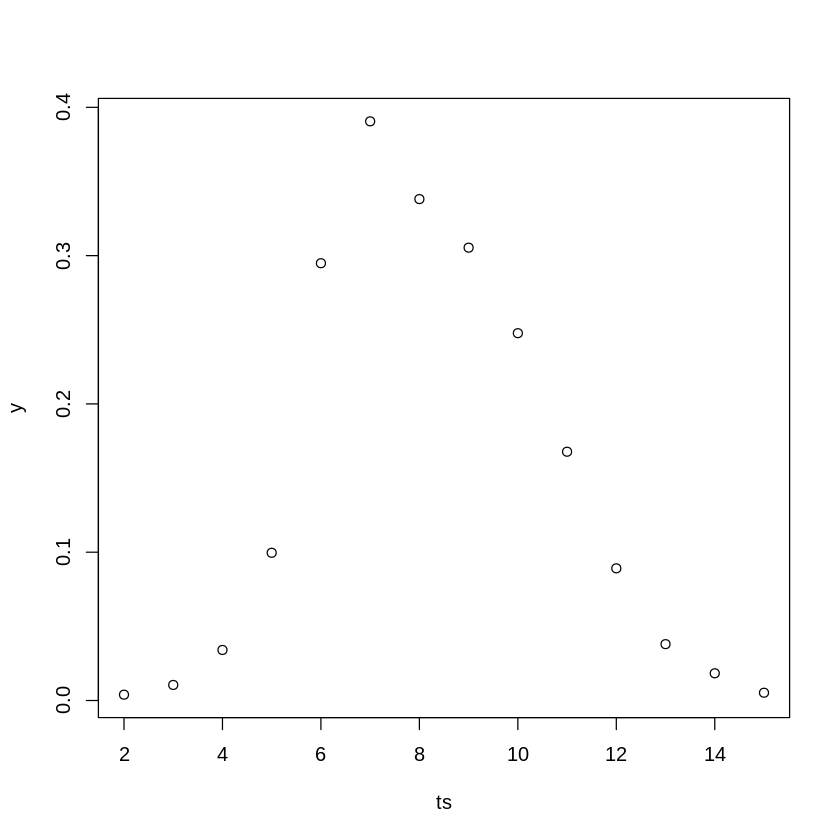

In [2]:
epi.data <- list(
  n_obs = length(noisy_I),
  t0 = iniTime,
  ts = forfit.sol$time,
  y_init = iniI,
  y = noisy_I,
  ab = 1,
  bb = 0.0010,
  ag = 1,
  bg = 0.0010,
#   mu_beta = 0,
#   sigma_beta = 1,
#   mu_gamma = 0,
#   sigma_gamma = 1,
  as = 9, #254,
  bs = 1#350-254
)
plot(epi.data$ts, epi.data$y, xlab = "ts", ylab = "y")

In [3]:
library(rstan)
rstan_options(auto_write = TRUE)
options(mc.cores = parallel::detectCores())
SIR_code <- stan_model(file = "/home/marcio/Projects/R0_uncertainty/R0_uncertainty/code/stan/sir_simple_I_norm.stan")

Loading required package: StanHeaders
Loading required package: ggplot2
rstan (Version 2.19.2, GitRev: 2e1f913d3ca3)
For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)


Warning message:
“The largest R-hat is 1.53, indicating chains have not mixed.
Running the chains for more iterations may help. See
http://mc-stan.org/misc/warnings.html#r-hat”Warning message:
“Bulk Effective Samples Size (ESS) is too low, indicating posterior means and medians may be unreliable.
Running the chains for more iterations may help. See
http://mc-stan.org/misc/warnings.html#bulk-ess”Warning message:
“Tail Effective Samples Size (ESS) is too low, indicating posterior variances and tail quantiles may be unreliable.
Running the chains for more iterations may help. See
http://mc-stan.org/misc/warnings.html#tail-ess”


Divergences:


0 of 4000 iterations ended with a divergence.



Tree depth:


0 of 4000 iterations saturated the maximum tree depth of 10.



Energy:


E-BFMI indicated no pathological behavior.


Inference for Stan model: sir_simple_I_norm.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

       mean se_mean   sd 2.5%   25%   50%   75% 97.5% n_eff Rhat
beta   5.46    1.46 2.16 1.77  3.62  6.31  6.98  8.11     2 3.33
gamma  0.36    0.11 0.16 0.22  0.26  0.29  0.39  0.71     2 3.57
S0     0.90    0.04 0.10 0.64  0.85  0.93  1.00  1.00     6 1.21
R0    19.04    6.58 9.78 2.56 11.62 22.50 25.78 31.87     2 3.10
sigma  0.86    0.15 0.22 0.37  0.89  0.98  0.99  1.00     2 3.55

Samples were drawn using NUTS(diag_e) at Wed Jun 10 21:35:30 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


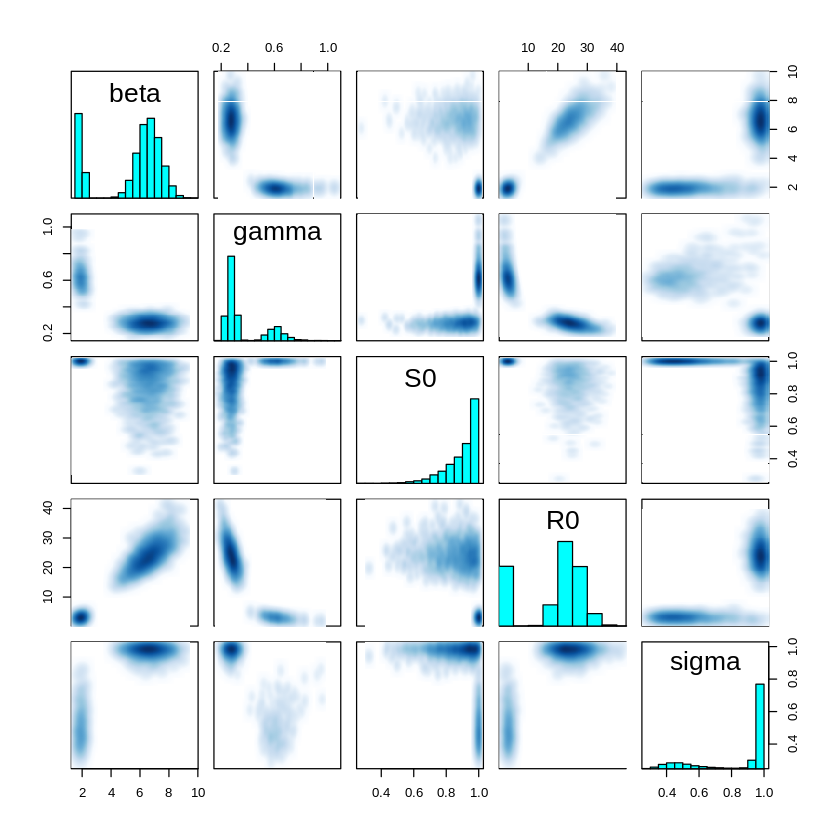

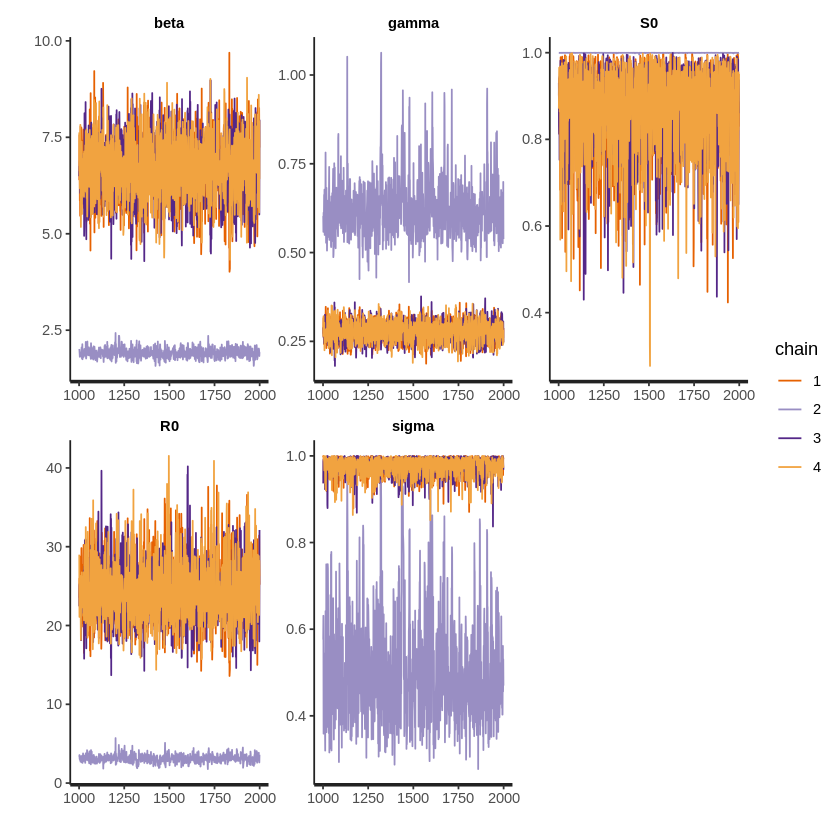

In [4]:
# SIR.map.s1 <- optimizing(SIR_code, data = epi.data, hessian = TRUE, verbose = TRUE)
SIR.posterior.s1 <- sampling(SIR_code, data = epi.data, chains = 4, control = list(adapt_delta = .99))
check_hmc_diagnostics(SIR.posterior.s1)
print(SIR.posterior.s1, pars = c("beta", "gamma", "S0", "R0", "sigma"))
pairs(SIR.posterior.s1, pars = c("beta", "gamma", "S0", "R0", "sigma"))
stan_trace(SIR.posterior.s1, pars = c("beta", "gamma", "S0", "R0", "sigma"))
simulated_trajectories.s1 <- extract(SIR.posterior.s1, 'y_rep')$y_rep
predicted.s1 <- data.frame(
  time = epi.data$ts,
  lower = apply(simulated_trajectories.s1, 2, function(x) as.numeric(quantile(x, probs = .025))),
  post_mean = colMeans(simulated_trajectories.s1),
  upper = apply(simulated_trajectories.s1, 2, function(x) as.numeric(quantile(x, probs = .975))),
  s = "1"
)